In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
data=pd.concat([train,test])
data.reset_index(inplace=True,drop=True)
data.drop('id',axis=1,inplace=True)

In [5]:
#80% of keyword data is missing.. better to drop that feature
data.isna().sum()/len(data)*100
data.drop(['keyword','location'],axis=1,inplace=True)

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
# More data cleaning in general
data['text']=data['text'].str.replace('\d', '')
data["text"] = data["text"].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',"")
data["text"] = data["text"].str.replace(r"We're", "We are")
data["text"] = data["text"].str.replace(r"That's", "That is")
data["text"] = data["text"].str.replace(r"won't", "will not")
data["text"] = data["text"].str.replace(r"they're", "they are")
data["text"] = data["text"].str.replace(r"Can't", "Cannot")
data["text"] = data["text"].str.replace(r"wasn't", "was not")
data["text"] = data["text"].str.replace(r"don\x89Ûªt", "do not")
data["text"] = data["text"].str.replace(r"aren't", "are not")
data["text"] = data["text"].str.replace(r"isn't", "is not")
data["text"] = data["text"].str.replace(r"You're", "You are")
data["text"] = data["text"].str.replace(r"I'M", "I am")
data["text"] = data["text"].str.replace(r"shouldn't", "should not")
data["text"] = data["text"].str.replace(r"wouldn't", "would not")
data["text"] = data["text"].str.replace(r"i'm", "I am")
data["text"] = data["text"].str.replace(r"We've", "We have")
data["text"] = data["text"].str.replace(r"Didn't", "Did not")
data["text"] = data["text"].str.replace(r"it's", "it is")
data["text"] = data["text"].str.replace(r"can't", "cannot")
data["text"] = data["text"].str.replace(r"don't", "do not")
data["text"] = data["text"].str.replace(r"you're", "you are")
data["text"] = data["text"].str.replace(r"I've", "I have")
data["text"] = data["text"].str.replace(r"Don't", "do not")
data["text"] = data["text"].str.replace(r"I'll", "I will")
data["text"] = data["text"].str.replace(r"Let's", "Let us")
data["text"] = data["text"].str.replace(r"Could've", "Could have")
data["text"] = data["text"].str.replace(r"youve", "you have")
data["text"] = data["text"].str.replace(r"It's", "It is")

In [8]:
data['text']

0        Our Deeds are the Reason of this #earthquake M...
1                   Forest fire near La Ronge Sask. Canada
2        All residents asked to 'shelter in place' are ...
3        , people receive #wildfires evacuation orders ...
4        Just got sent this photo from Ruby #Alaska as ...
                               ...                        
10871    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
10872    Storm in RI worse than last hurricane. My city...
10873                    Green Line derailment in Chicago 
10874          MEG issues Hazardous Weather Outlook (HWO) 
10875    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

In [9]:
lemmatizer=WordNetLemmatizer()
sw=stopwords.words("english")
sw.append("u")
sw.append("im")
#Don't forget word_tokenize() and lower()

In [171]:
data['tweet_length']=data['text'].apply(lambda x: len([(w) for w in str(x).split()]))

In [172]:
data['unique_length']=data['text'].apply(lambda x: len([(w) for w in set(str(x).split() ) ]))

In [177]:
data

,text,target,text_lem,unique_length,tweet_length
0,our deeds are the reason of this #earthquake m...,1.0,our deed are the reason of this #earthquake ma...,13,13
1,forest fire near la ronge sask. canada,1.0,forest fire near la ronge sask. canada,7,7
2,all residents asked to 'shelter in place' are ...,1.0,all resident asked to 'shelter in place' are b...,20,22
3,", people receive #wildfires evacuation orders ...",1.0,", people receive #wildfires evacuation order i...",8,8
4,just got sent this photo from ruby #alaska as ...,1.0,just got sent this photo from ruby #alaska a s...,15,16
...,...,...,...,...,...
10871,earthquake safety los angeles ûò safety faste...,NaN,earthquake safety los angeles ûò safety faste...,7,8
10872,storm in ri worse than last hurricane. my city...,NaN,storm in ri worse than last hurricane. my city...,22,23
10873,green line derailment in chicago,NaN,green line derailment in chicago,5,5
10874,meg issues hazardous weather outlook (hwo),NaN,meg issue hazardous weather outlook (hwo),6,6


In [10]:
def lemmatize_tokenize(document):
    #lem=WordNetLemmatizer()
    stemmer = SnowballStemmer(language='english')
    token=word_tokenize(document)
    return [stemmer.stem(t) for t in token if t.isalpha()
                        and t.lower() not in sw]

In [11]:
#Lowercase, lemmatize, tokenize, vectorize (+ remove stopwords,ngrams, even lowercase here) Does vectorization already tokenzie for you?
data['text']=data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#data['text_lem']=[lemmatizer.lemmatize(x) for x in data['text']]

In [12]:
text_lem=[]
y=0
for x in data['text']:
    new_row=[lemmatizer.lemmatize(y) for y in x.split()]
    new_row=' '.join(new_row)
    data.loc[y,'text_lem']=new_row
    y+=1
    #print(new_row)

In [13]:
data['text_lem'][:100]

0     our deed are the reason of this #earthquake ma...
1                forest fire near la ronge sask. canada
2     all resident asked to 'shelter in place' are b...
3     , people receive #wildfires evacuation order i...
4     just got sent this photo from ruby #alaska a s...
                            ...                        
95    mile backup on i- south...accident blocking th...
96    ha an accident changed your life? we will help...
97    #breaking: there wa a deadly motorcycle car ac...
98    @flowri were you marinading it or wa it an acc...
99    only had a car for not even a week and got in ...
Name: text_lem, Length: 100, dtype: object

In [14]:
tfidf=TfidfVectorizer(ngram_range=(1,3),stop_words=sw)

In [15]:
X=tfidf.fit_transform(data['text_lem'])

In [16]:
from sklearn.decomposition import TruncatedSVD
pca=TruncatedSVD(n_components=2)
X_pca=pca.fit_transform(X)

2D feature reduction explains variance of 0.601 %


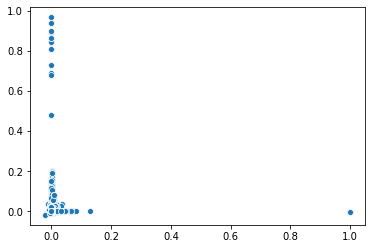

In [17]:
sns.scatterplot(X_pca[:,0],X_pca[:,1])
print(f"2D feature reduction explains variance of {round(sum(pca.explained_variance_ratio_)*100,3)} %")

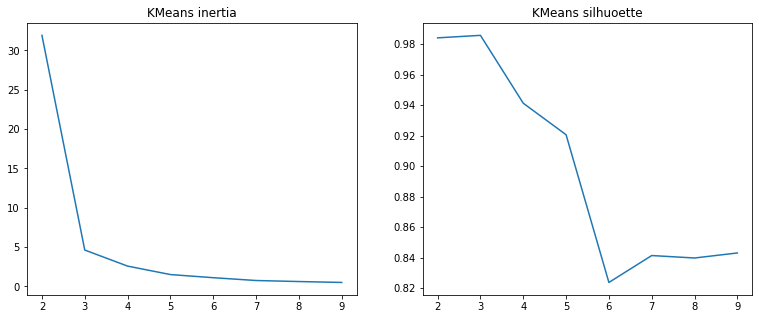

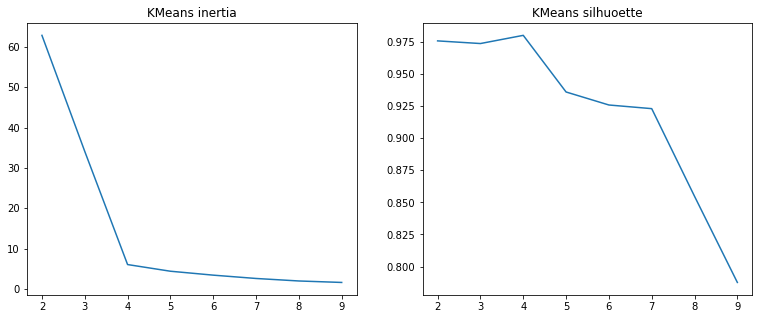

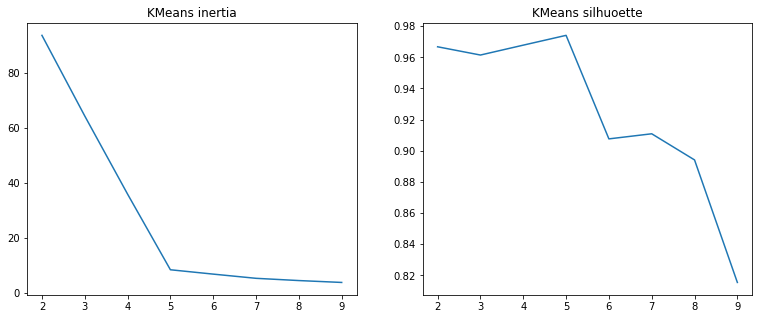

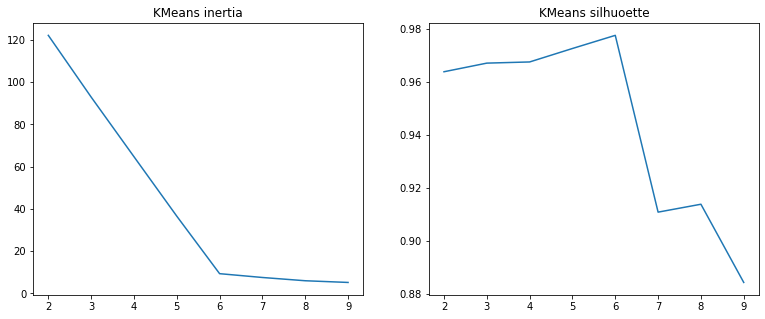

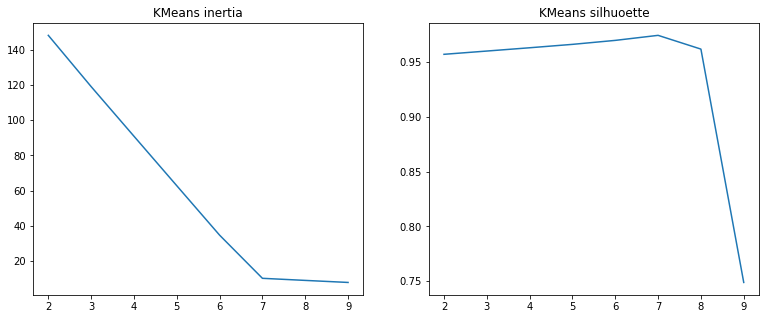

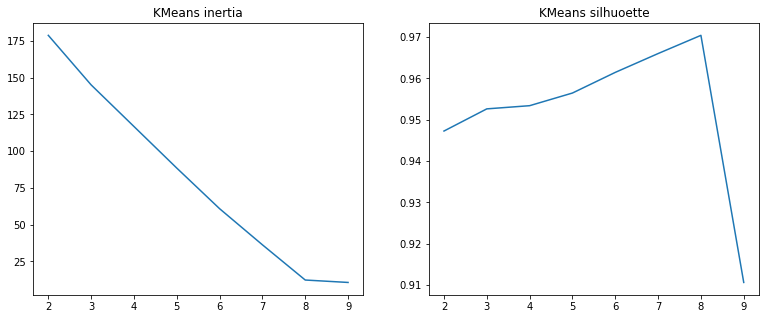

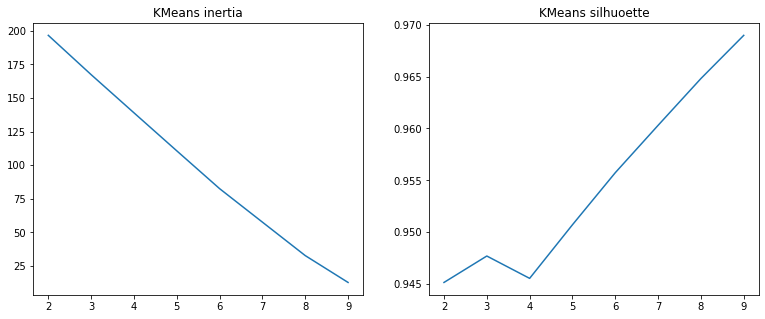

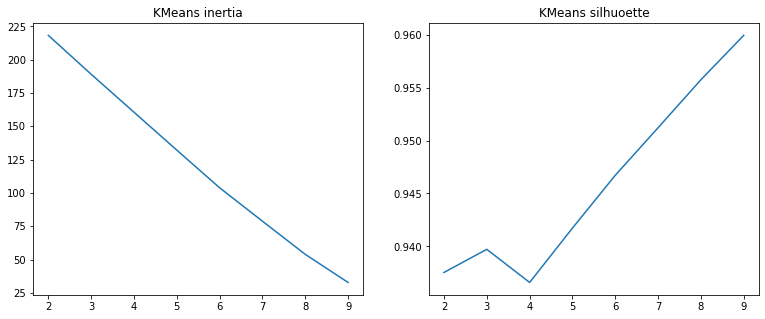

In [18]:
from sklearn.cluster import KMeans#, AgglomerativeClustering
from sklearn.metrics import silhouette_score

for x in range(2,10):
    pca=TruncatedSVD(n_components=x)
    X_pca=pca.fit_transform(X)
    kmeans_df=pd.DataFrame(columns=['inertia','silhouette'],index=range(2,10))
    
    for k in kmeans_df.index:
        km=KMeans(n_clusters=k)
        km.fit(X_pca)
        kmeans_df.loc[k,'inertia']=km.inertia_
        kmeans_df.loc[k,'silhouette']=silhouette_score(X_pca,km.predict(X_pca))

    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    plt.plot(kmeans_df["inertia"]),plt.title("KMeans inertia")
    plt.subplot(1,2,2)
    plt.plot(kmeans_df["silhouette"]),plt.title("KMeans silhuoette")

In [20]:
#Continue Kmeans clustering with 3 clusters?

pca=TruncatedSVD(n_components=2)
km=KMeans(n_clusters=4)
X_pca=pca.fit_transform(X)
km.fit(X_pca)
mask=km.predict(X_pca)

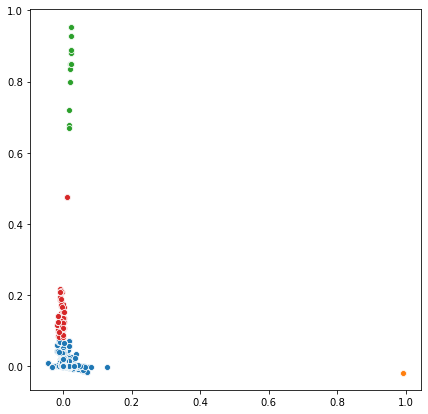

In [21]:
plt.figure(figsize=(7,7))
for i in range(km.n_clusters):
    sns.scatterplot(x=X_pca[mask==i,0],y=X_pca[mask==i,1])

In [22]:
freq=train['text'][0:1000].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

In [23]:
ntrain=len(train)
X_training_data=X[:ntrain]
X_testing_data=X[ntrain:]
y_training_data=data['target'][:ntrain]

In [90]:
from sklearn.model_selection import train_test_split, cross_validate,RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,f1_score
X_train,X_test,y_train,y_test=train_test_split(X_training_data,y_training_data,stratify=y_training_data,random_state=42)

In [63]:
#5 dimensions seem to work for now
for n in range(2,10):
    lr=SGDClassifier(loss='log')
    pca=TruncatedSVD(n_components=3)
    X_train_pca=pca.fit_transform(X_train)
    X_test_pca=pca.transform(X_test)
    lr.fit(X_train_pca,y_train)
    training_score=cross_validate(lr,X_train_pca,y_train,scoring='f1_weighted',cv=3)['test_score'].mean()
    print(f'Feature reduction to {n} dimensions gives a training f1 score of {round(training_score,4)}') 

Feature reduction to 2 dimensions gives a training f1 score of 0.5013
Feature reduction to 3 dimensions gives a training f1 score of 0.5152
Feature reduction to 4 dimensions gives a training f1 score of 0.5338
Feature reduction to 5 dimensions gives a training f1 score of 0.5464
Feature reduction to 6 dimensions gives a training f1 score of 0.5312
Feature reduction to 7 dimensions gives a training f1 score of 0.5428
Feature reduction to 8 dimensions gives a training f1 score of 0.4897
Feature reduction to 9 dimensions gives a training f1 score of 0.4812


In [71]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import time

pca=TruncatedSVD(n_components=5)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)

lr=SGDClassifier(loss='log')
svc=SVC(probability=True)
knn=KNeighborsClassifier()
dtr=DecisionTreeClassifier()
rfc=RandomForestClassifier()

models={"Logistic regression":lr,"Support vector classifier": svc,"K neighbours classifier":knn, \
       "Decision tree classifier": dtr, "Random forest classifier": rfc}

In [74]:
#Untuned model predictions and score
#This implies the data is non-linear (duh it's freaking text). Props to K nieghbours & RFC.
base_model_scores=pd.DataFrame(index=models.keys(),columns=[["training score","testing score"]])
t0=time.time()
for key,model in models.items():
    model.fit(X_train_pca,y_train)
    train_score=cross_validate(model,X_train_pca,y_train,scoring='f1_weighted',cv=3)['test_score'].mean()
    pred=model.predict(X_test_pca)
    f1=f1_score(y_test,pred,average='weighted')
    base_model_scores.loc[key,"training score"]=train_score.mean()
    base_model_scores.loc[key,"testing score"]=f1
    print(time.time()-t0)
base_model_scores

0.10509729385375977
21.082321882247925
21.7042338848114
21.972847938537598
29.67129135131836


,training score,testing score
Logistic regression,0.506712,0.597012
Support vector classifier,0.582447,0.604653
K neighbours classifier,0.650834,0.687628
Decision tree classifier,0.615462,0.639865
Random forest classifier,0.677651,0.697312


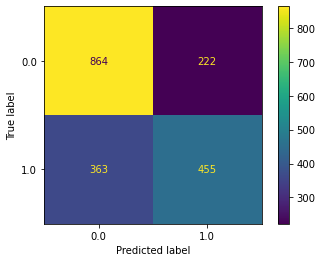

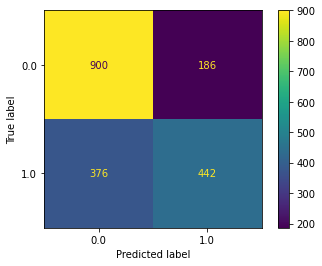

In [81]:
plot_confusion_matrix(knn,X_test_pca,y_test)
plot_confusion_matrix(rfc,X_test_pca,y_test)

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [109]:
knn?

In [144]:
knn_params={
    'n_neighbors': range(3,8),
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(5,15),
    'p':[1,2]
    
}

rfc_params= {
    'n_estimators': range(100,600,50),
    'criterion': ['gini','entropy'],
    'max_samples': np.arange(0.1,1,0.1),
    'max_features': range(5,10,2)
}

In [145]:
knn_random=RandomizedSearchCV(knn,param_distributions=knn_params,scoring='f1_weighted',cv=3, verbose=10)
knn_random.fit(X_train_pca,y_train)
knn_random.best_params_,knn_random.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] p=1, n_neighbors=3, leaf_size=14, algorithm=kd_tree .............
[CV]  p=1, n_neighbors=3, leaf_size=14, algorithm=kd_tree, score=0.646, total=   0.1s
[CV] p=1, n_neighbors=3, leaf_size=14, algorithm=kd_tree .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  p=1, n_neighbors=3, leaf_size=14, algorithm=kd_tree, score=0.651, total=   0.1s
[CV] p=1, n_neighbors=3, leaf_size=14, algorithm=kd_tree .............
[CV]  p=1, n_neighbors=3, leaf_size=14, algorithm=kd_tree, score=0.637, total=   0.1s
[CV] p=2, n_neighbors=3, leaf_size=13, algorithm=ball_tree ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV]  p=2, n_neighbors=3, leaf_size=13, algorithm=ball_tree, score=0.647, total=   0.3s
[CV] p=2, n_neighbors=3, leaf_size=13, algorithm=ball_tree ...........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


[CV]  p=2, n_neighbors=3, leaf_size=13, algorithm=ball_tree, score=0.659, total=   0.3s
[CV] p=2, n_neighbors=3, leaf_size=13, algorithm=ball_tree ...........


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s


[CV]  p=2, n_neighbors=3, leaf_size=13, algorithm=ball_tree, score=0.640, total=   0.2s
[CV] p=2, n_neighbors=6, leaf_size=6, algorithm=brute ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s


[CV]  p=2, n_neighbors=6, leaf_size=6, algorithm=brute, score=0.666, total=   0.4s
[CV] p=2, n_neighbors=6, leaf_size=6, algorithm=brute ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.5s remaining:    0.0s


[CV]  p=2, n_neighbors=6, leaf_size=6, algorithm=brute, score=0.653, total=   0.4s
[CV] p=2, n_neighbors=6, leaf_size=6, algorithm=brute ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.9s remaining:    0.0s


[CV]  p=2, n_neighbors=6, leaf_size=6, algorithm=brute, score=0.643, total=   0.4s
[CV] p=2, n_neighbors=6, leaf_size=13, algorithm=kd_tree .............
[CV]  p=2, n_neighbors=6, leaf_size=13, algorithm=kd_tree, score=0.666, total=   0.2s
[CV] p=2, n_neighbors=6, leaf_size=13, algorithm=kd_tree .............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.3s remaining:    0.0s


[CV]  p=2, n_neighbors=6, leaf_size=13, algorithm=kd_tree, score=0.653, total=   0.2s
[CV] p=2, n_neighbors=6, leaf_size=13, algorithm=kd_tree .............
[CV]  p=2, n_neighbors=6, leaf_size=13, algorithm=kd_tree, score=0.642, total=   0.2s
[CV] p=1, n_neighbors=5, leaf_size=8, algorithm=auto .................
[CV]  p=1, n_neighbors=5, leaf_size=8, algorithm=auto, score=0.661, total=   0.2s
[CV] p=1, n_neighbors=5, leaf_size=8, algorithm=auto .................
[CV]  p=1, n_neighbors=5, leaf_size=8, algorithm=auto, score=0.665, total=   0.1s
[CV] p=1, n_neighbors=5, leaf_size=8, algorithm=auto .................
[CV]  p=1, n_neighbors=5, leaf_size=8, algorithm=auto, score=0.630, total=   0.2s
[CV] p=2, n_neighbors=7, leaf_size=9, algorithm=ball_tree ............
[CV]  p=2, n_neighbors=7, leaf_size=9, algorithm=ball_tree, score=0.661, total=   0.3s
[CV] p=2, n_neighbors=7, leaf_size=9, algorithm=ball_tree ............
[CV]  p=2, n_neighbors=7, leaf_size=9, algorithm=ball_tree, score=0.6

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.9s finished


({'p': 2, 'n_neighbors': 6, 'leaf_size': 6, 'algorithm': 'brute'},
 0.6536435868005784)

In [148]:
f1_score(y_test,knn_random.best_estimator_.predict(X_test_pca),average='weighted')

0.6743589568460994

In [149]:
rfc_random=RandomizedSearchCV(rfc,param_distributions=rfc_params,scoring='f1_weighted',cv=3, verbose=10)
rfc_random.fit(X_train_pca,y_train)
rfc_random.best_params_,rfc_random.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=550, max_samples=0.30000000000000004, max_features=9, criterion=gini 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\

[CV]  n_estimators=550, max_samples=0.30000000000000004, max_features=9, criterion=gini, score=nan, total=   0.4s
[CV] n_estimators=550, max_samples=0.30000000000000004, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=550, max_samples=0.30000000000000004, max_features=9, criterion=gini, score=nan, total=   0.5s
[CV] n_estimators=550, max_samples=0.30000000000000004, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=550, max_samples=0.30000000000000004, max_features=9, criterion=gini, score=nan, total=   0.5s
[CV] n_estimators=500, max_samples=0.30000000000000004, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=500, max_samples=0.30000000000000004, max_features=9, criterion=gini, score=nan, total=   0.4s
[CV] n_estimators=500, max_samples=0.30000000000000004, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=500, max_samples=0.30000000000000004, max_features=9, criterion=gini, score=nan, total=   0.4s
[CV] n_estimators=500, max_samples=0.30000000000000004, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=500, max_samples=0.30000000000000004, max_features=9, criterion=gini, score=nan, total=   0.4s
[CV] n_estimators=250, max_samples=0.6, max_features=7, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=250, max_samples=0.6, max_features=7, criterion=gini, score=nan, total=   0.2s
[CV] n_estimators=250, max_samples=0.6, max_features=7, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=250, max_samples=0.6, max_features=7, criterion=gini, score=nan, total=   0.2s
[CV] n_estimators=250, max_samples=0.6, max_features=7, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=250, max_samples=0.6, max_features=7, criterion=gini, score=nan, total=   0.2s
[CV] n_estimators=350, max_samples=0.6, max_features=9, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=350, max_samples=0.6, max_features=9, criterion=entropy, score=nan, total=   0.3s
[CV] n_estimators=350, max_samples=0.6, max_features=9, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=350, max_samples=0.6, max_features=9, criterion=entropy, score=nan, total=   0.3s
[CV] n_estimators=350, max_samples=0.6, max_features=9, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=350, max_samples=0.6, max_features=9, criterion=entropy, score=nan, total=   0.3s
[CV] n_estimators=400, max_samples=0.5, max_features=9, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=400, max_samples=0.5, max_features=9, criterion=entropy, score=nan, total=   0.4s
[CV] n_estimators=400, max_samples=0.5, max_features=9, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=400, max_samples=0.5, max_features=9, criterion=entropy, score=nan, total=   0.4s
[CV] n_estimators=400, max_samples=0.5, max_features=9, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=400, max_samples=0.5, max_features=9, criterion=entropy, score=nan, total=   0.4s
[CV] n_estimators=500, max_samples=0.7000000000000001, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=500, max_samples=0.7000000000000001, max_features=9, criterion=gini, score=nan, total=   0.4s
[CV] n_estimators=500, max_samples=0.7000000000000001, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=500, max_samples=0.7000000000000001, max_features=9, criterion=gini, score=nan, total=   0.4s
[CV] n_estimators=500, max_samples=0.7000000000000001, max_features=9, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=500, max_samples=0.7000000000000001, max_features=9, criterion=gini, score=nan, total=   0.4s
[CV] n_estimators=300, max_samples=0.5, max_features=7, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=300, max_samples=0.5, max_features=7, criterion=gini, score=nan, total=   0.3s
[CV] n_estimators=300, max_samples=0.5, max_features=7, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=300, max_samples=0.5, max_features=7, criterion=gini, score=nan, total=   0.3s
[CV] n_estimators=300, max_samples=0.5, max_features=7, criterion=gini 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=300, max_samples=0.5, max_features=7, criterion=gini, score=nan, total=   0.3s
[CV] n_estimators=450, max_samples=0.1, max_features=5, criterion=gini 
[CV]  n_estimators=450, max_samples=0.1, max_features=5, criterion=gini, score=0.689, total=   2.8s
[CV] n_estimators=450, max_samples=0.1, max_features=5, criterion=gini 
[CV]  n_estimators=450, max_samples=0.1, max_features=5, criterion=gini, score=0.684, total=   2.8s
[CV] n_estimators=450, max_samples=0.1, max_features=5, criterion=gini 
[CV]  n_estimators=450, max_samples=0.1, max_features=5, criterion=gini, score=0.684, total=   2.8s
[CV] n_estimators=150, max_samples=0.9, max_features=9, criterion=entropy 
[CV]  n_estimators=150, max_samples=0.9, max_features=9, criterion=entropy, score=nan, total=   0.1s
[CV] n_estimators=150, max_samples=0.9, max_features=9, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=150, max_samples=0.9, max_features=9, criterion=entropy, score=nan, total=   0.1s
[CV] n_estimators=150, max_samples=0.9, max_features=9, criterion=entropy 
[CV]  n_estimators=150, max_samples=0.9, max_features=9, criterion=entropy, score=nan, total=   0.1s
[CV] n_estimators=450, max_samples=0.5, max_features=7, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=450, max_samples=0.5, max_features=7, criterion=entropy, score=nan, total=   0.4s
[CV] n_estimators=450, max_samples=0.5, max_features=7, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=450, max_samples=0.5, max_features=7, criterion=entropy, score=nan, total=   0.4s
[CV] n_estimators=450, max_samples=0.5, max_features=7, criterion=entropy 


C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 1029, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\joblib\parallel.py", line 765, in _dispatch
    job = se

[CV]  n_estimators=450, max_samples=0.5, max_features=7, criterion=entropy, score=nan, total=   0.4s


({'n_estimators': 450,
  'max_samples': 0.1,
  'max_features': 5,
  'criterion': 'gini'},
 0.6859013574413364)

In [150]:
f1_score(y_test,rfc_random.best_estimator_.predict(X_test_pca),average='weighted')

0.6988808485598688

In [153]:
Pipeline(steps=[("rfc",rfc_random.best_estimator_),("knn",knn_random.best_estimator_ )])

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'RandomForestClassifier(max_features=5, max_samples=0.1, n_estimators=450)' (type <class 'sklearn.ensemble._forest.RandomForestClassifier'>) doesn't

In [75]:
pipeline_sgd=Pipeline(steps=[('tfidf',tfidf),('sgd',SGDClassifier() )])

#Workshop params
pipeline_params = {
    'sgd__loss': ['hinge', 'log'],
    'sgd__penalty': ['l1', 'l2', 'elasticnet'],
    'sgd__alpha': [.0001, .0005, .001]    
}
# Apparently my params don't work... maybe its the way the keys are spelled
#pipeline_params={
#    'sgd_loss': ['hinge','log'],
#    'sgd_penalty': ['l2','l1','elasticnet'],
#    'sgd_alpha': [0.0001,0.0005,0.001]
#    
#}

In [77]:
def fit_cross_validate_model(algo,params,X_train,X_test,y_train,y_test):
    gs=GridSearchCV(algo,params,scoring=['precision_macro','recall_macro','accuracy'],refit='precision_macro',n_jobs=4,verbose=10)
    gs.fit(X_train,y_train)
    print('best params: ',gs.best_params_)
    print('score on test set: ',gs.score(X_test,y_test))
    return( gs , gs.predict(X_test) )

In [78]:
gs_sgd , pred_sgd  =fit_cross_validate_model(pipeline_sgd,pipeline_params,X_train,X_test,y_train,y_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   36.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.4s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   56.1s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.6min finished


best params:  {'sgd__alpha': 0.001, 'sgd__loss': 'hinge', 'sgd__penalty': 'l2'}
score on test set:  0.8203968253968255


In [80]:
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1086
           1       0.90      0.56      0.69       818

    accuracy                           0.78      1904
   macro avg       0.82      0.75      0.76      1904
weighted avg       0.81      0.78      0.77      1904

